In [1]:
import rasterio
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
plt.rcParams['figure.figsize'] = [8.0, 6.0]
from sklearn.model_selection import train_test_split

# Load weather data
weatherData = np.load('FullweatherData.npy')
# Order: ppt, tmax, tmean, tmin

# Load loc
ds = rasterio.open('PRISMdaily\PRISM_ppt_stable_4kmD2_19920101_bil.bil')
affine = ds.affine
loc = np.load('FullLocData.npy')

# Change loc to give latitude and longitude
ix = loc[:,0]
iy = loc[:,1]
nx, ny = 140, 62 # Need to be the same as when I produced FullLocData.npy
ybin = np.linspace(0,621,ny, dtype=int)
xbin = np.linspace(0,1405,nx, dtype=int)
yloc = ybin[iy]
xloc = xbin[ix]

xtobin = {}
prevx = xloc[0]
istart = 0
for i, x in enumerate(xloc[1:]):
    if x != prevx:
        xtobin[prevx] = (istart, i)
        istart = i+1
    prevx = x
xtobin[prevx] = (istart, len(xloc)-1)

# Load new dataframe for fire data with condition such that I can use the weather data
conn = sqlite3.connect('FPA_FOD_20170508.sqlite')
c = conn.cursor()
c.execute('''SELECT DISCOVERY_DATE, LATITUDE, LONGITUDE, STAT_CAUSE_DESCR 
FROM FIRES''')
rows = c.fetchall()
df = pd.DataFrame(rows)
df.columns = ['stime', 'lat', 'lon', 'cause']

# drop Alaska, Hawaii, Puerto Rico
df = df[df['lon']>-130.]
df = df[df['lat']>24.]
df = df[df['lat']<50.]

epoch = pd.to_datetime(0).to_julian_date()
df['stime'] = pd.to_datetime(df['stime']-epoch, unit='D')

# I only want fire which starts after at least one month in 1992 and before 2000 right now
df = df[(df['stime']<pd.to_datetime('2000-01-01')) & 
        (df['stime']>pd.to_datetime('1992-01-31'))].copy()

def binarysearch(lon,xbin,beg,end):
    if beg == end:
        return xtobin[xbin[beg]]
    if beg == end-1 and lon < xbin[end]:
        return xtobin[xbin[beg]]
    center = (beg+end)//2
    value = xbin[center]
    if lon >= value:
        return binarysearch(lon,xbin,center,end)
    return binarysearch(lon,xbin,beg,center)
    
def binarysearch2(lon,xbin,beg,end):
    if beg == end:
        return beg
    if beg == end-1:
        if lon == xbin[end]:
            return end
        return beg
    center = (beg+end)//2
    value = xbin[center]
    if lon >= value:
        return binarysearch2(lon,xbin,center,end)
    return binarysearch2(lon,xbin,beg,center)

def findxybin(lon,lat):
    beg, end = binarysearch(lon,xbin,0,len(xbin)-1)
    if lat > yloc[end]:
        return end
    return binarysearch2(lat,yloc,beg,end)

# Convert longitude latitude to the bin value
lonarray = (df['lon'].values - affine[2])//affine[0]
latarray = (df['lat'].values - affine[5])//affine[4]

xybinarray = np.vectorize(findxybin,otypes=[int])(lonarray,latarray)

def findtime(arr):
    # time is number of day since 1992-01-01
    return (arr - pd.to_datetime('1992-01-01')).dt.days

# get weather data
def moddf(df):
    tarray = df['tarray'].values
    xybinarray = df['xybinarray'].values
    
    df['sppt'] = weatherData[tarray, xybinarray,0]
    df['stmax'] = weatherData[tarray, xybinarray,1]
    df['stmean'] = weatherData[tarray, xybinarray,2]
    df['stmin'] = weatherData[tarray, xybinarray,3]

    # Look at accumulated precipitation since 30 days and mean temperature
    df['1mppt'] = df['sppt']
    df['1mtmax'] = df['stmax']
    df['1mtmean'] = df['stmean']
    df['1mtmin'] = df['stmin']
    for i in range(1,31):
        df['1mppt'] += weatherData[tarray-i, xybinarray,0]
        df['1mtmax'] += weatherData[tarray-i, xybinarray,1]
        df['1mtmean'] += weatherData[tarray-i, xybinarray,2]
        df['1mtmin'] += weatherData[tarray-i, xybinarray,3]

    df['1mtmax'] /= 31
    df['1mtmean'] /= 31
    df['1mtmin'] /= 31

    df['1wppt'] = df['sppt']
    df['1wtmax'] = df['stmax']
    df['1wtmean'] = df['stmean']
    df['1wtmin'] = df['stmin']
    for i in range(1,7):
        df['1wppt'] += weatherData[tarray-i, xybinarray,0]
        df['1wtmax'] += weatherData[tarray-i, xybinarray,1]
        df['1wtmean'] += weatherData[tarray-i, xybinarray,2]
        df['1wtmin'] += weatherData[tarray-i, xybinarray,3]

    df['1wtmax'] /= 7
    df['1wtmean'] /= 7
    df['1wtmin'] /= 7
    
    df['2wppt'] = df['sppt']
    df['2wtmax'] = df['stmax']
    df['2wtmean'] = df['stmean']
    df['2wtmin'] = df['stmin']
    for i in range(1,14):
        df['2wppt'] += weatherData[tarray-i, xybinarray,0]
        df['2wtmax'] += weatherData[tarray-i, xybinarray,1]
        df['2wtmean'] += weatherData[tarray-i, xybinarray,2]
        df['2wtmin'] += weatherData[tarray-i, xybinarray,3]

    df['2wtmax'] /= 14
    df['2wtmean'] /= 14
    df['2wtmin'] /= 14
    return df

def createfake(firepredict):
    s = len(firepredict)
    lonlat = firepredict[['lon','lat']].sample(n=s,replace=True).reset_index(drop=True)
    t = firepredict['tarray'].sample(n=s,replace=True).reset_index(drop=True)
    fakefire = lonlat.join(t)

    fakefire['day'] = fakefire['tarray'].apply(lambda x: (pd.Timedelta(x,'D') + pd.to_datetime('1992-01-01')).dayofyear)

    # get xybin
    lonarray = (fakefire['lon'].values - affine[2])//affine[0]
    latarray = (fakefire['lat'].values - affine[5])//affine[4]
    fakefire['xybinarray'] = np.vectorize(findxybin,otypes=[int])(lonarray,latarray)

    fakefire = moddf(fakefire)

    # align columns
    firepredict, fakefire = firepredict.align(fakefire,axis=1,copy=False)
    
    fakefire['fire']=False
    firepredict['fire']=True
    return pd.concat([fakefire,firepredict])
    
tarray = findtime(df['stime'])
df['day'] = df['stime'].dt.dayofyear
df['tarray'] = tarray
df['xybinarray'] = xybinarray

# Save

In [2]:
display(df.head())

,stime,lat,lon,cause,day,tarray,xybinarray
41875,1992-05-19,45.360000,-113.078333,Lightning,140,139,947
41876,1992-08-05,44.540000,-112.683333,Lightning,218,217,990
41877,1992-10-05,44.516667,-112.983333,Campfire,279,278,949
41878,1992-10-24,44.690000,-112.730000,Campfire,298,297,990
41879,1992-06-07,45.763333,-112.820000,Campfire,159,158,946


In [4]:
df0 = df.drop(['cause', 'stime'],axis=1)
def createfake(firepredict):
    s = len(firepredict)
    lonlat = firepredict[['lon','lat']].sample(n=s,replace=True).reset_index(drop=True)
    t = firepredict['tarray'].sample(n=s,replace=True).reset_index(drop=True)
    fakefire = lonlat.join(t)

    fakefire['day'] = fakefire['tarray'].apply(lambda x: (pd.Timedelta(x,'D') + pd.to_datetime('1992-01-01')).dayofyear)

    # get xybin
    lonarray = (fakefire['lon'].values - affine[2])//affine[0]
    latarray = (fakefire['lat'].values - affine[5])//affine[4]
    fakefire['xybinarray'] = np.vectorize(findxybin,otypes=[int])(lonarray,latarray)

    # fakefire = moddf(fakefire) # Remove moddf because I don't want to create new feature before saving

    # align columns
    firepredict, fakefire = firepredict.align(fakefire,axis=1,copy=False)
    
    fakefire['fire']=False
    firepredict['fire']=True
    return pd.concat([fakefire,firepredict])

df0 = createfake(df0)
np.save('FireData', df0.values, allow_pickle=True, fix_imports=False)

In [5]:
list(df0)

['day', 'lat', 'lon', 'tarray', 'xybinarray', 'fire']

Now, I can do:

weatherData = np.load('FullweatherData.npy')

df = pd.DataFrame(np.load('FireData.npy'), columns=['day', 'lat', 'lon', 'tarray', 'xybinarray', 'fire'])

And I have everything I need to use moddf(df)

I could potentially remove day and xybinarray to reduce memory, but I will have to recompute them afterwards and the memory needed is not that big.

# Test random forest

100 0.7118310673994793 175.2173101902008
200 0.7130556359078198 175.11783409118652
300 0.7141934239706875 176.2358202934265
400 0.7141934239706875 205.52946496009827


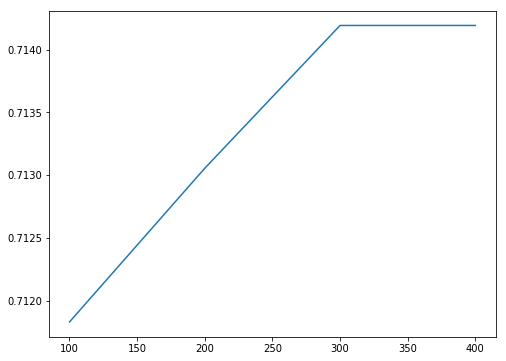

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier as rfc
from time import time

firepredict = moddf(df.drop(['cause', 'stime'],axis=1))
train_df = createfake(firepredict)

X, X_test, y, y_test = train_test_split(
    train_df.drop('fire',axis=1), train_df['fire'], test_size=0.08, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, shuffle=True)

def fitRFC(X_train,X_val,y_train, y_val,nTree, deltaTree, rf):
    nrange = range(deltaTree, nTree, deltaTree)
    score = []
    for n_estimators in nrange:
        start_time = time()
        rf.n_estimators = n_estimators
        sc = rf.fit(X_train,y_train).score(X_val, y_val)
        score.append(sc)
        print(n_estimators, sc, time()-start_time)
    plt.plot(nrange,score)

rf = rfc(n_jobs=-1, warm_start=True)
fitRFC(X_train.drop(['tarray','xybinarray'],axis=1), X_val.drop(['tarray','xybinarray'],axis=1), 
            y_train, y_val, 500, 100, rf)

Test accuracy is:  0.7090249825355112
Test precision is:  0.6970017114966087
Test recall is:  0.7348734628408483


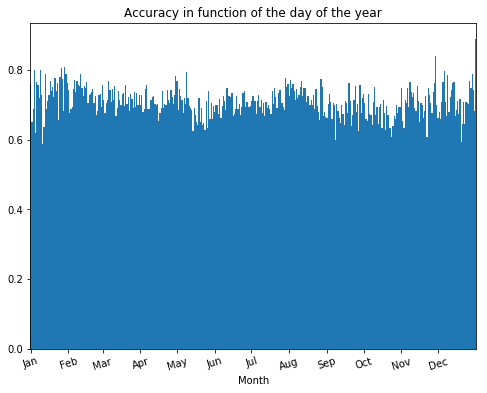

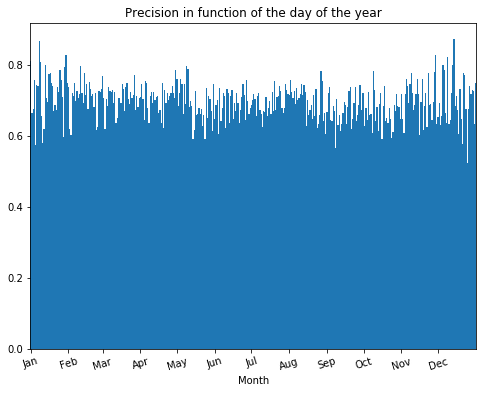

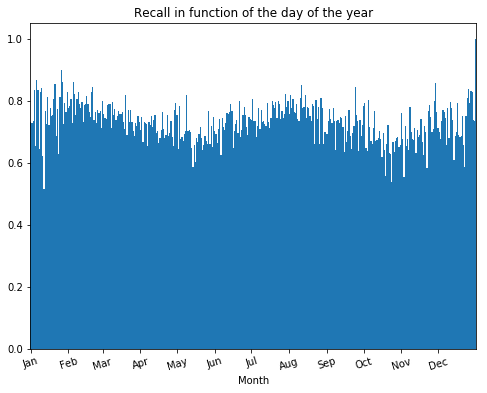

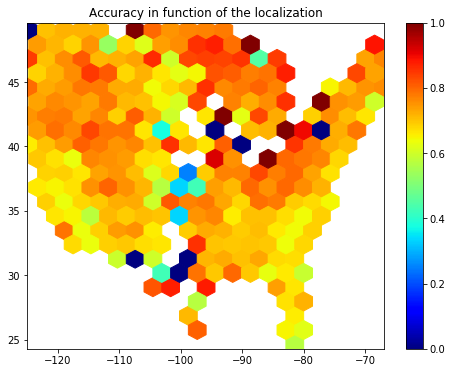

In [15]:
from matplotlib import cm, colors
def dayplot2(df1, df,title):
    hist = (df1.groupby(['day']).size()/df.groupby(['day']).size()).values
    width = 1
    center = np.arange(0.5,366.5)
    plt.bar(center, hist, align='edge', width=width)
    month=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    # Those numbers don't work for leap year, but it doesn't really matter.
    day =[1,32,60,91,121,152,182,213,244,274,305,335]
    plt.xticks(day, month, rotation=17)
    ax=plt.gca()
    ax.set_xlim((0.5,366.5))
    plt.xlabel('Month')
    plt.title(title+' in function of the day of the year')
    plt.show()
def mapplot2(df):
    gridsize=20
    plt.hexbin(df['lon'].values, df['lat'].values, (df['truth']==df['pred']).values,
               gridsize=gridsize, reduce_C_function=np.mean, cmap=cm.jet)
    cb = plt.colorbar()
    plt.title('Accuracy in function of the localization')
    ax = plt.gca()
    ax.set_xlim((-125,-66.9))
    ax.set_ylim((24.3,49.6))
    plt.show()

y_pred = rf.predict(X_test.drop(['tarray','xybinarray'],axis=1).values)
acc_df = X_test[y_test==y_pred] # dataframe of the correctly labelled examples
tp_df = X_test[y_test & y_pred] # true positive
fp_df = X_test[(~ y_test) & y_pred] # false positive
fn_df = X_test[y_test & (~ y_pred)] # false negative

print('Test accuracy is: ', len(acc_df)/len(X_test))
print('Test precision is: ', len(tp_df)/(len(tp_df)+len(fp_df)))
print('Test recall is: ', len(tp_df)/(len(tp_df)+len(fn_df)))

dayplot2(acc_df,X_test,'Accuracy')
dayplot2(tp_df,pd.concat([tp_df,fp_df]),'Precision')
dayplot2(tp_df,pd.concat([tp_df,fn_df]),'Recall')

map_df = X_test.copy()
map_df['truth'] = y_test
map_df['pred'] = y_pred
mapplot2(map_df)

Compare to XGBoost, the random forest has an accuracy and precision slightly less good, and a recall significantly less good. It could potentially be improved by hyperparameter tuning, but hyperparameter tuning does not usually improve the results by much for a random forest, and increasing the number of trees, but at 400 trees the random forest takes already significantly more time than XGBoost to train and the accuracy did not improve between 300 and 400 trees.

# Test XGBoost with more features

I use the first cell of this notebook, but then replace moddf.

In [6]:
def moddf(df):
    tarray = df['tarray'].values
    xybinarray = df['xybinarray'].values
    
    df['ppt0'] = weatherData[tarray, xybinarray,0]
    df['tmax0'] = weatherData[tarray, xybinarray,1]
    df['tmean0'] = weatherData[tarray, xybinarray,2]
    df['tmin0'] = weatherData[tarray, xybinarray,3]
    for i in range(1,31):
        df['ppt'+str(i)] = df['ppt'+str(i-1)] + weatherData[tarray-i, xybinarray,0]
        df['tmax'+str(i)] = df['tmax'+str(i-1)] + weatherData[tarray-i, xybinarray,1]
        df['tmean'+str(i)] = df['tmean'+str(i-1)] + weatherData[tarray-i, xybinarray,2]
        df['tmin'+str(i)] = df['tmin'+str(i-1)] + weatherData[tarray-i, xybinarray,3]
    return df

In [13]:
from xgboost import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from time import time

def hypersearch(X_train, X_val, y_train, y_val, trials, max_evals):
    def objective(space):
        param={'learning_rate' : space['learning_rate'],
         'max_depth' : int(space['max_depth']),
         'min_child_weight' : space['min_child_weight'],
            'gamma' : space['gamma'],
         'subsample' : space['subsample'],
         'colsample_bytree' :space['colsample_bytree'],
         'nthread' : -1,
               'reg_alpha' : space['reg_alpha'],
               'reg_lambda' : space['reg_lambda'],
               'colsample_bylevel': space['colsample_bylevel']
              }
        start_time = time()
        clf = XGBClassifier(**param, n_estimators=1000)
        clf.fit(X = X_train.values, y = y_train.values, eval_metric='error', early_stopping_rounds=30, 
                        eval_set = [(X_val.values, y_val.values)], verbose=False)
        error = min(clf.evals_result()['validation_0']['error'])
        print(param)
        print(time() - start_time, error)
        return{'loss':error, 'status': STATUS_OK }


    space ={
            'max_depth': hp.quniform ('max_depth', 1, 18, 1),
            'min_child_weight': hp.quniform ('min_child_weight', 1, 10, 1),
            'subsample': hp.uniform ('subsample', 0.1, 1.),
            'learning_rate' : hp.uniform ('learning_rate', 0.01, 0.5),
           'colsample_bytree': hp.uniform ('colsample_bytree', 0.5, 1.),
            'gamma': hp.uniform ('gamma', 0., 1.),
        'reg_alpha': hp.uniform ('reg_alpha', 0., 1.),
        'reg_lambda': hp.uniform ('reg_lambda', 0., 1.),
        'colsample_bylevel': hp.uniform ('colsample_bylevel', 0.5, 1.)
        }

    best = fmin(fn=objective,
                space=space,
                algo=tpe.suggest,
                max_evals=max_evals,
                trials=trials)

    best['max_depth'] = int(best['max_depth'])
    print(best)

def fitandplot(X_train, X_val, y_train, y_val, clf):
    clf.fit(X = X_train.values, y = y_train.values, eval_metric='error', early_stopping_rounds=30, 
                    eval_set = [(X_val.values, y_val.values)], verbose=True)
    print(min(clf.evals_result()['validation_0']['error']))

    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.rcParams['text.usetex']=False
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X_train.shape[1]), importances[indices],
           color="r", align="center")
    plt.xticks(range(X_train.shape[1]), X_train.columns.values[indices], rotation=25)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()

In [8]:
firepredict = moddf(df.drop(['cause', 'stime'],axis=1))
train_df = createfake(firepredict)

X, X_test, y, y_test = train_test_split(
    train_df.drop('fire',axis=1), train_df['fire'], test_size=0.1, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, shuffle=True)

trials = Trials()

In [ ]:
hypersearch(X_train.drop(['tarray','xybinarray'],axis=1), X_val.drop(['tarray','xybinarray'],axis=1), y_train, y_val, trials, 5)